# Parametric Poisson equation 

This notebook implements Poisson equation where diffusivity is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. You can use it to create a new conda environment and run the scripts in this repository:
```sh
conda env create -f neuralop.yml
```

In [1]:
import sys 
import numpy as np
import dolfin as dl
import hippylib as hp

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot, load_cmap
from classUtilities import GenericReprBase

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
mycmap_fn = util_path + '/erdc_cyan2orange.pkl'
cyan2orange = load_cmap(mycmap_fn, cmap_name = 'cyan2orange')

# Main model class
This will be ultimately moved to a python script but for now we will keep it here for testing purposes. The class has two component: (1) class to sample diffusivity field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [3]:
class PriorSampler(GenericReprBase):
    
    def __init__(self, Vm, correlation_length, seed = 0):

        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(1.)
        self.scale = dl.Constant(0.1)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class PoissonModel(GenericReprBase):
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), 50, 50)
        self.Vu = dl.FunctionSpace(self.mesh, "Lagrange", 1)
        self.Vm = self.Vu
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.f = dl.Expression("1000*(1-x[1])*x[1]*(1-x[0])*(1-x[0])", degree=2)
        self.q = dl.Expression("50*sin(5*pi*x[1])", degree=2)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)
        self.a = self.m_fn*dl.inner(dl.nabla_grad(self.u_trial), dl.nabla_grad(self.u_test))*dl.dx 
        self.L = self.f*self.u_test*dl.dx \
                 + self.q*self.u_test*dl.ds # boundary term
        self.varf = self.a - self.L
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant(0), self.boundaryU)]

        # setup prior for parameter field m
        self.prior_sampler = PriorSampler(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryU(x, on_boundary):
        return on_boundary and x[0] < 1. - dl.DOLFIN_EPS

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test Poisson model

In [4]:
correlation_length = 2
model = PoissonModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of diffusivity and solve the forward problem

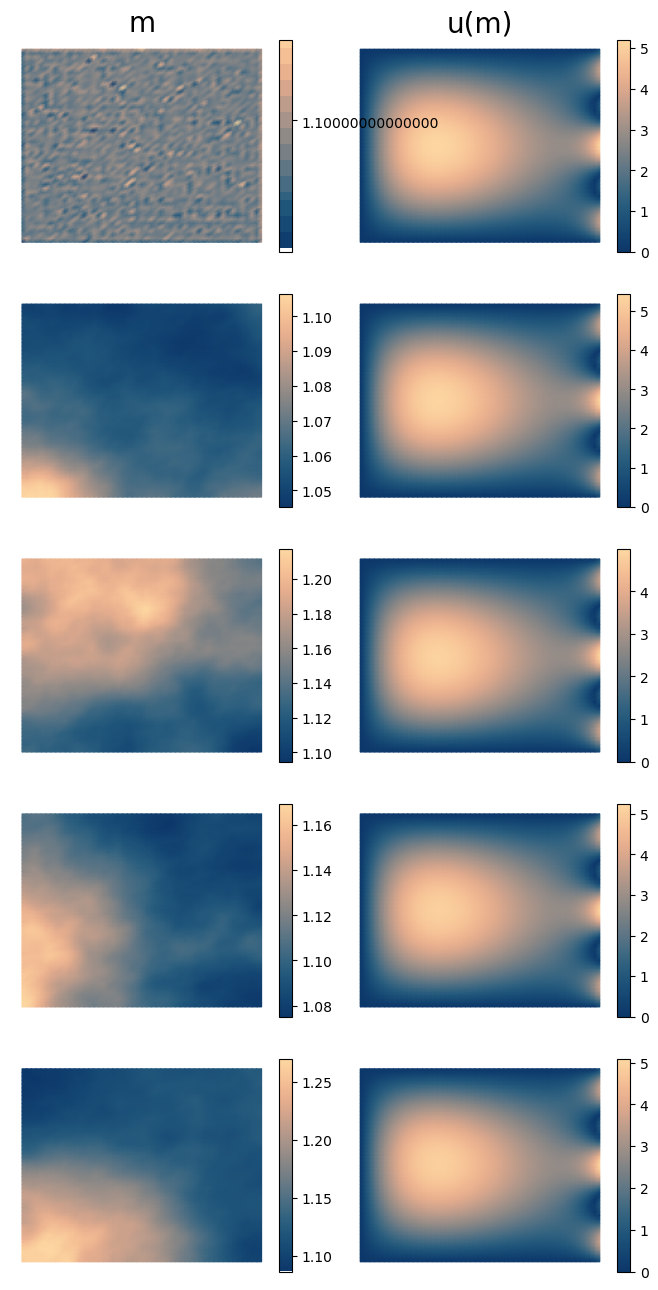

In [5]:
nrows = 5
ncols = 2
lfs = 20
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 16))

u_vec = None
u_tag = ['m', 'u(m)']
cmap_vec = [cyan2orange, cyan2orange]

m = dl.Function(model.Vm).vector()
u = dl.Function(model.Vu).vector()

for j in range(nrows):

    m.zero()
    if j > 0:
        m.axpy(1., model.prior_sampler.get())
    else:
        m.axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m, m_is_fn = False)
    u = model.u_fn.vector()
    
    u_vec = [m, u]

    for i in range(ncols):
        V = model.Vu
        if i == 0:
            V = model.Vm
            
        cbar = field_plot(axs[j,i], u_vec[i], V, show_cbar = True, cmap = cmap_vec[i])
        divider = make_axes_locatable(axs[j,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(cbar, cax=cax, orientation='vertical')
        if j == 0:
            axs[j,i].set_title(u_tag[i], fontsize=lfs)
        axs[j,i].axis('off')
    
plt.show()

In [6]:
a = m.get_local()
print(a.min(), a.max(), a.mean(), a.std())

1.0863289372951315 1.2699181228589957 1.1483446922348546 0.045767906540009326
